In [190]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline
 
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2)

import warnings

warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [191]:
train_df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [192]:
train_df[['Deck', 'Num', 'Side']] = train_df['Cabin'].str.split('/', expand=True) # Separate cabin data in deck, num, and side
test_df[['Deck', 'Num', 'Side']] = test_df['Cabin'].str.split('/', expand=True)

train_df[['Group', 'PassengerNum']] = train_df['PassengerId'].str.split('_', expand=True) # Separate cabin data in deck, num, and side
test_df[['Group', 'PassengerNum']] = test_df['PassengerId'].str.split('_', expand=True)

In [193]:
train_df['Group_size'] = train_df['Group'].map(lambda x: pd.concat([train_df['Group'], test_df['Group']]).value_counts()[x])
test_df['Group_size'] = test_df['Group'].map(lambda x: pd.concat([train_df['Group'], test_df['Group']]).value_counts()[x])

In [194]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,Group,PassengerNum,Group_size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P,0001,01,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S,0002,01,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S,0003,01,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S,0003,02,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S,0004,01,1


In [195]:
train_df.drop(['PassengerId', 'Name', 'Cabin', 'Group', 'PassengerNum'],axis=1,inplace=True)
test_df.drop(['Name', 'Cabin', 'Group', 'PassengerNum'],axis=1,inplace=True)

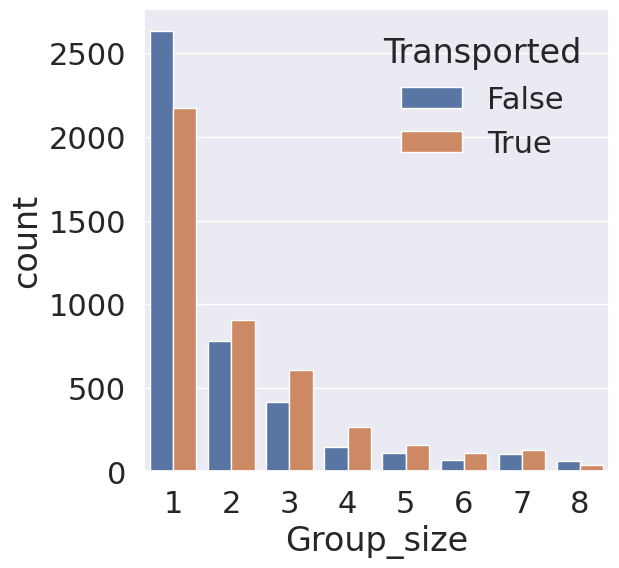

In [196]:
fig, ax = plt.subplots(figsize=(6,6))
 
sns.countplot(data=train_df, x='Group_size', hue='Transported', ax=ax)
 
plt.show()

# ****Handling Missing Values****

In [197]:
train_df.isnull().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
Deck            199
Num             199
Side            199
Group_size        0
dtype: int64

In [198]:
test_df.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Deck            100
Num             100
Side            100
Group_size        0
dtype: int64

In [199]:
for col in train_df.select_dtypes('object').columns: # Replace NaN values in Norminal data columns with mode value
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

In [200]:
for col in train_df.select_dtypes('number').columns: # Replace NaN values in Norminal data columns with mode value
    train_df[col] = train_df[col].fillna(train_df[col].median())

In [201]:
for col in test_df.select_dtypes('object').columns: # Replace NaN values in Norminal data columns with mode value
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

In [202]:
for col in test_df.select_dtypes('number').columns: # Replace NaN values in Norminal data columns with mode value
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

In [203]:
train_df.isnull().sum() 

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Deck            0
Num             0
Side            0
Group_size      0
dtype: int64

In [204]:
test_df.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Deck            0
Num             0
Side            0
Group_size      0
dtype: int64

# ****Data Preprocessing****

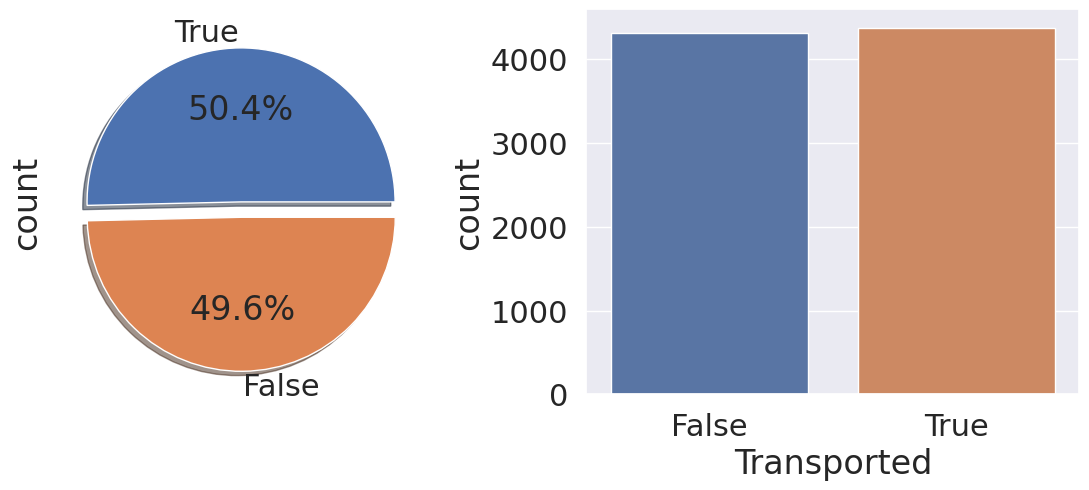

In [205]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
 
train_df['Transported'].value_counts().plot.pie(ax=ax[0], explode=[0,0.1], shadow=True, autopct='%1.1f%%')
 
sns.countplot(data=train_df, x='Transported', ax=ax[1])
 
plt.show()

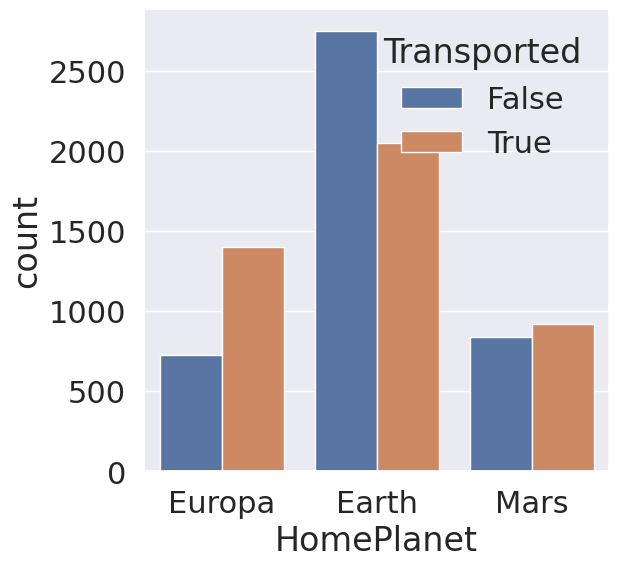

In [206]:
fig, ax = plt.subplots(figsize=(6,6))
 
sns.countplot(data=train_df, x='HomePlanet', hue='Transported', ax=ax)
 
plt.show()

In [207]:
train_df[['HomePlanet', 'Transported']].groupby(['HomePlanet'], as_index=False).mean().sort_values(by='Transported', ascending=False)

,HomePlanet,Transported
1,Europa,0.658846
2,Mars,0.523024
0,Earth,0.427649


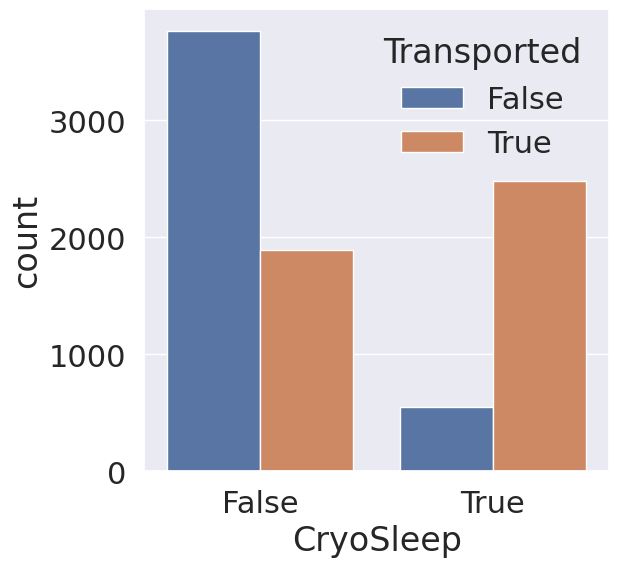

In [208]:
fig, ax = plt.subplots(figsize=(6,6))
 
sns.countplot(data=train_df, x='CryoSleep', hue='Transported', ax=ax)
 
plt.show()

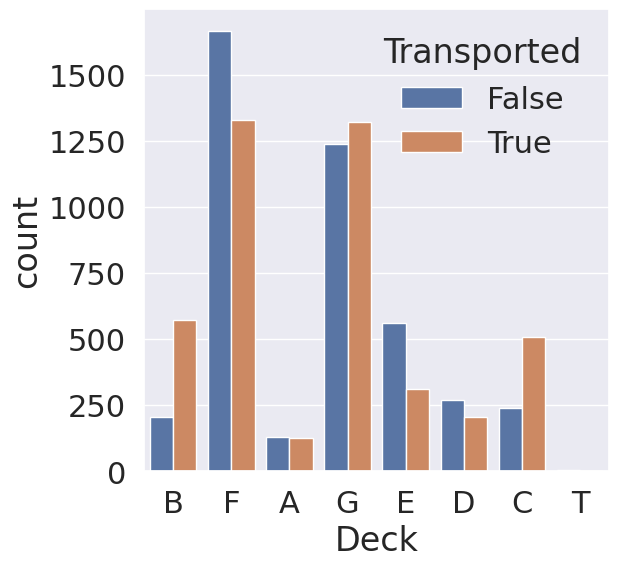

In [209]:
fig, ax = plt.subplots(figsize=(6,6))
 
sns.countplot(data=train_df, x='Deck', hue='Transported', ax=ax)
 
plt.show()

In [210]:
train_df[['Deck', 'Transported']].groupby(['Deck'], as_index=False).mean().sort_values(by='Transported', ascending=False)

,Deck,Transported
1,B,0.734275
2,C,0.680054
6,G,0.516217
0,A,0.496094
5,F,0.444036
3,D,0.433054
4,E,0.357306
7,T,0.200000


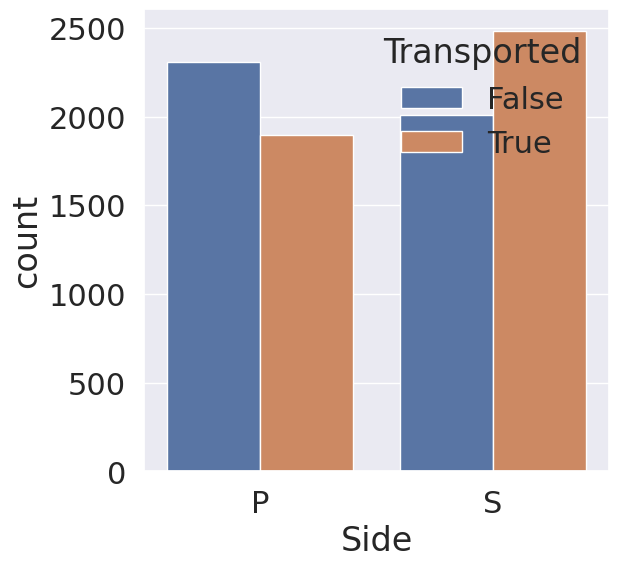

In [211]:
fig, ax = plt.subplots(figsize=(6,6))
 
sns.countplot(data=train_df, x='Side', hue='Transported', ax=ax)
 
plt.show()

In [212]:
train_df[['Side', 'Transported']].groupby(['Side'], as_index=False).mean().sort_values(by='Transported', ascending=False)

,Side,Transported
1,S,0.552708
0,P,0.451260


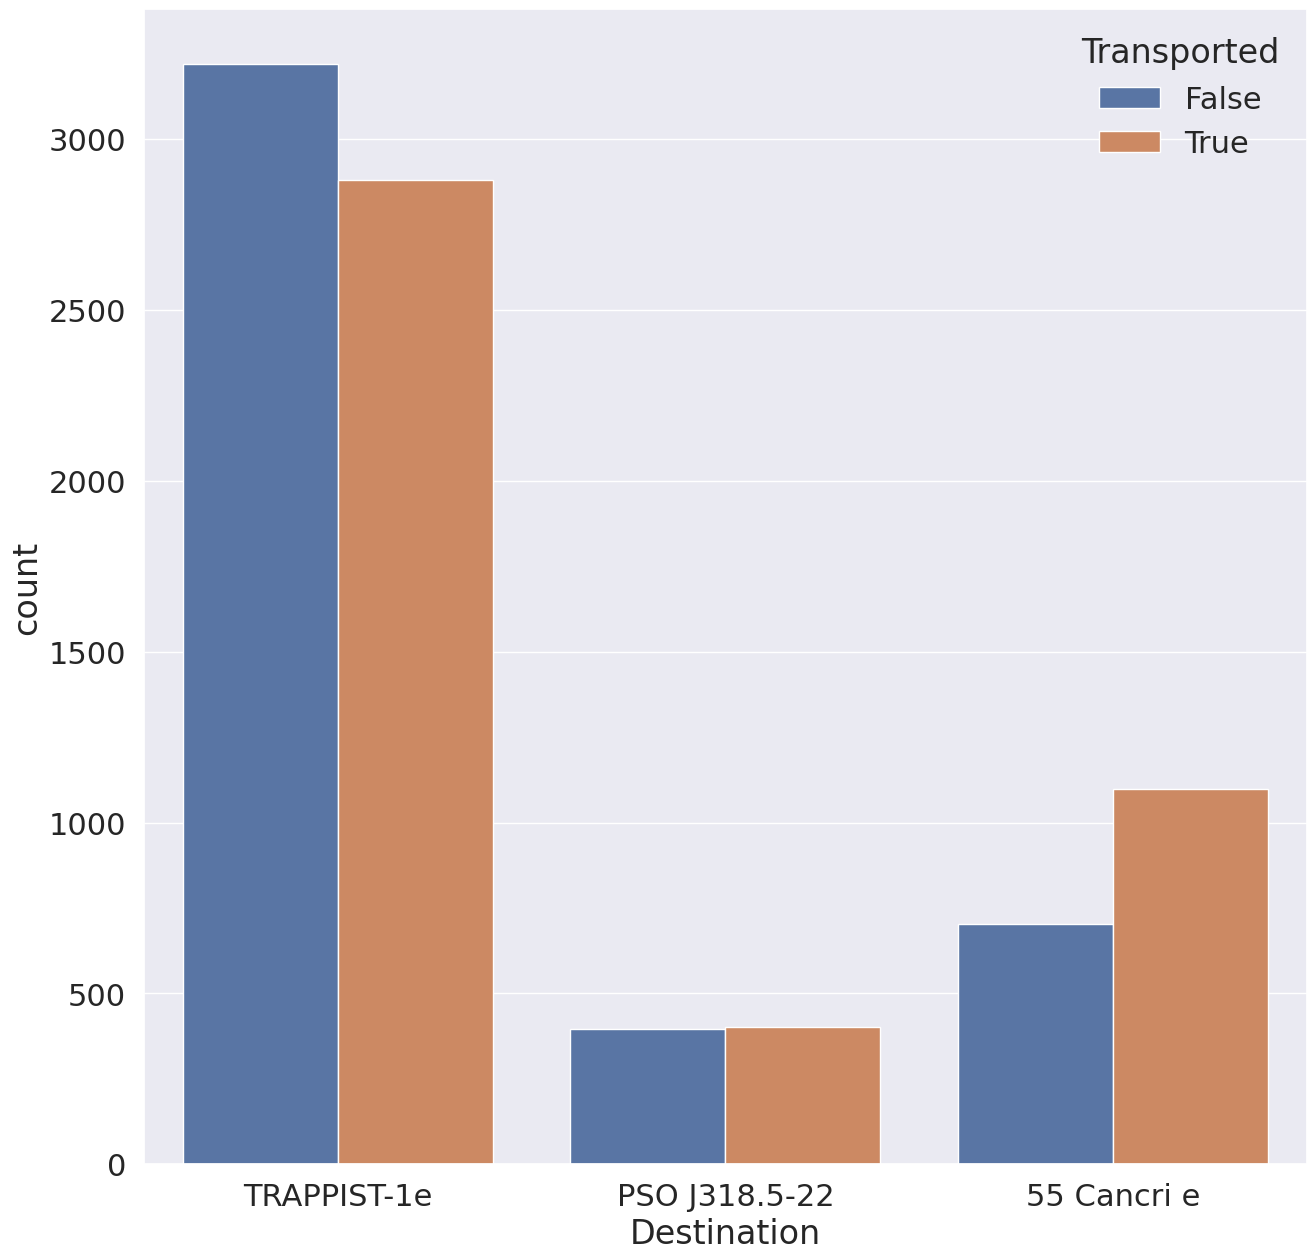

In [213]:
fig, ax = plt.subplots(figsize=(15,15))
 
sns.countplot(data=train_df, x='Destination', hue='Transported', ax=ax)
 
plt.show()

In [214]:
train_df[['Destination', 'Transported']].groupby(['Destination'], as_index=False).mean().sort_values(by='Transported', ascending=False)

,Destination,Transported
0,55 Cancri e,0.610000
1,PSO J318.5-22,0.503769
2,TRAPPIST-1e,0.472199


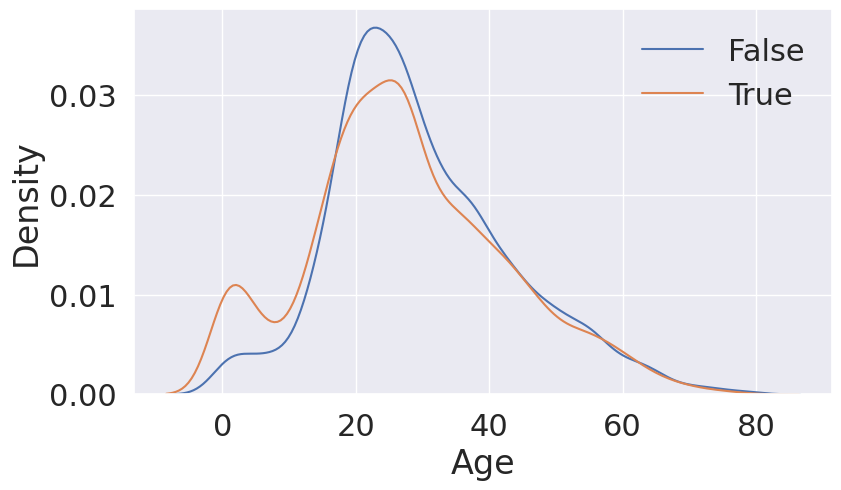

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(train_df[train_df['Transported'] == False]['Age'], ax=ax)
sns.kdeplot(train_df[train_df['Transported'] == True]['Age'], ax=ax)
lable = ['False', 'True']
plt.legend(labels=lable)
plt.show()


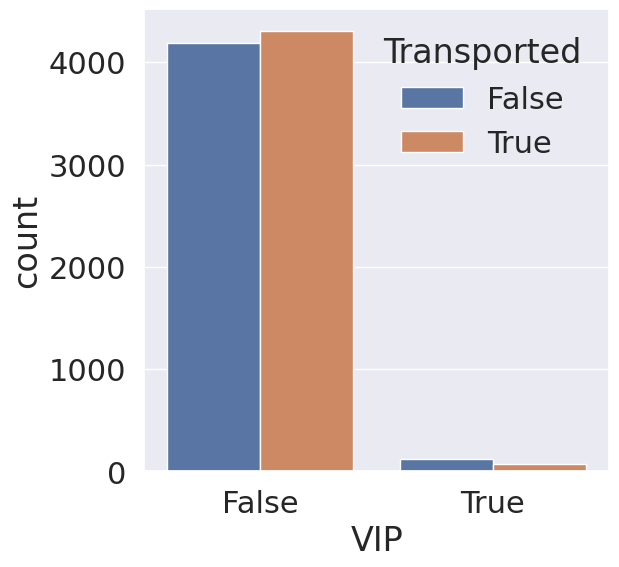

In [216]:
fig, ax = plt.subplots(figsize=(6,6))
 
sns.countplot(data=train_df, x='VIP', hue='Transported', ax=ax)
 
plt.show()

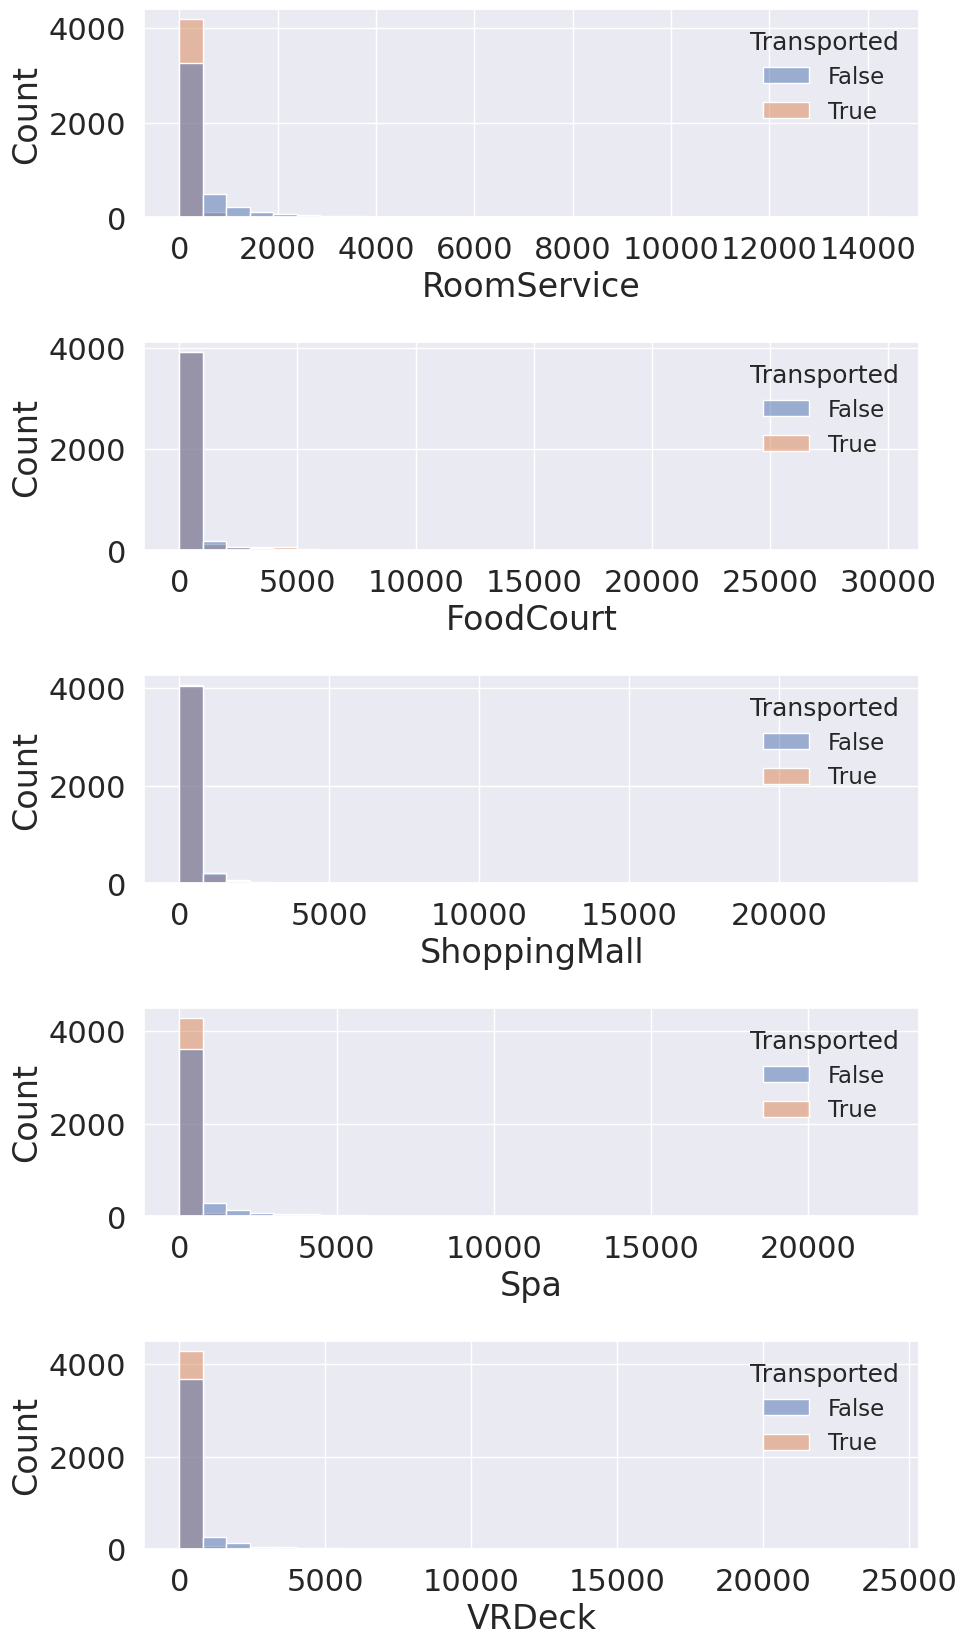

In [217]:
fig, ax = plt.subplots(5, 1, figsize=(10, 20))
fig.subplots_adjust(hspace=0.6,wspace=0.6)
sns.set(font_scale=1.5)

num_list = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for i, columns in enumerate(num_list):
    sns.histplot(data=train_df, x=columns, ax=ax[i], bins=30, kde=False, hue='Transported')

plt.show()

In [218]:
log_list = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for i in log_list:
    train_df[i] = np.log1p(train_df[i])
    test_df[i] = np.log1p(test_df[i])

In [219]:
train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,Group_size
0,Europa,False,TRAPPIST-1e,39.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,False,B,0,P,1
1,Earth,False,TRAPPIST-1e,24.0,False,4.700480,2.302585,3.258097,6.309918,3.806662,True,F,0,S,1
2,Europa,False,TRAPPIST-1e,58.0,True,3.784190,8.182280,0.000000,8.812248,3.912023,False,A,0,S,2
3,Europa,False,TRAPPIST-1e,33.0,False,0.000000,7.157735,5.918894,8.110728,5.267858,False,A,0,S,2
4,Earth,False,TRAPPIST-1e,16.0,False,5.717028,4.262680,5.023881,6.338594,1.098612,True,F,1,S,1


In [220]:
int_list = ['CryoSleep', 'VIP', 'Num']

for i in int_list:
    train_df[i] = train_df[i].astype('int')
    test_df[i] = test_df[i].astype('int')

In [221]:
train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,Group_size
0,Europa,0,TRAPPIST-1e,39.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,False,B,0,P,1
1,Earth,0,TRAPPIST-1e,24.0,0,4.700480,2.302585,3.258097,6.309918,3.806662,True,F,0,S,1
2,Europa,0,TRAPPIST-1e,58.0,1,3.784190,8.182280,0.000000,8.812248,3.912023,False,A,0,S,2
3,Europa,0,TRAPPIST-1e,33.0,0,0.000000,7.157735,5.918894,8.110728,5.267858,False,A,0,S,2
4,Earth,0,TRAPPIST-1e,16.0,0,5.717028,4.262680,5.023881,6.338594,1.098612,True,F,1,S,1


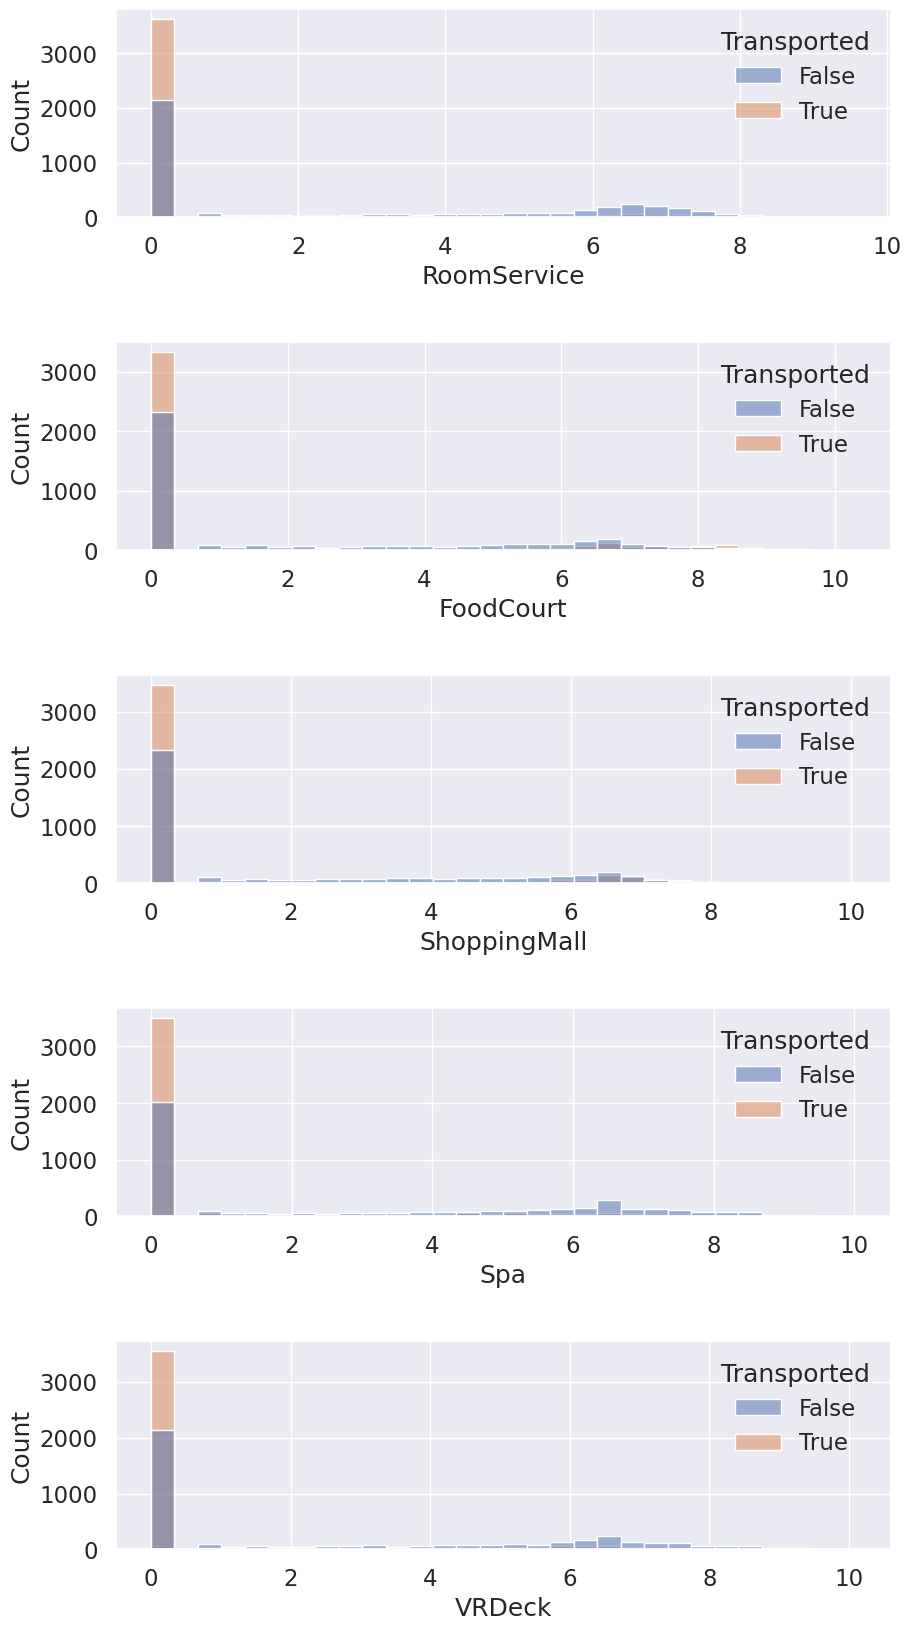

In [222]:
fig, ax = plt.subplots(5, 1, figsize=(10, 20))
fig.subplots_adjust(hspace=0.6,wspace=0.6)
sns.set(font_scale=1.5)

num_list = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for i, columns in enumerate(num_list):
    sns.histplot(data=train_df, x=columns, ax=ax[i], bins=30, kde=False, hue='Transported')

plt.show()

In [223]:
label_list = ['HomePlanet', 'Destination', 'Deck', 'Num', 'Side']

for i in label_list:
    le = LabelEncoder()

    le = le.fit(train_df[i])

    train_df[i] = le.transform(train_df[i])

    for label in test_df[i]:
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_,label)

    test_df[i] = le.transform(test_df[i])

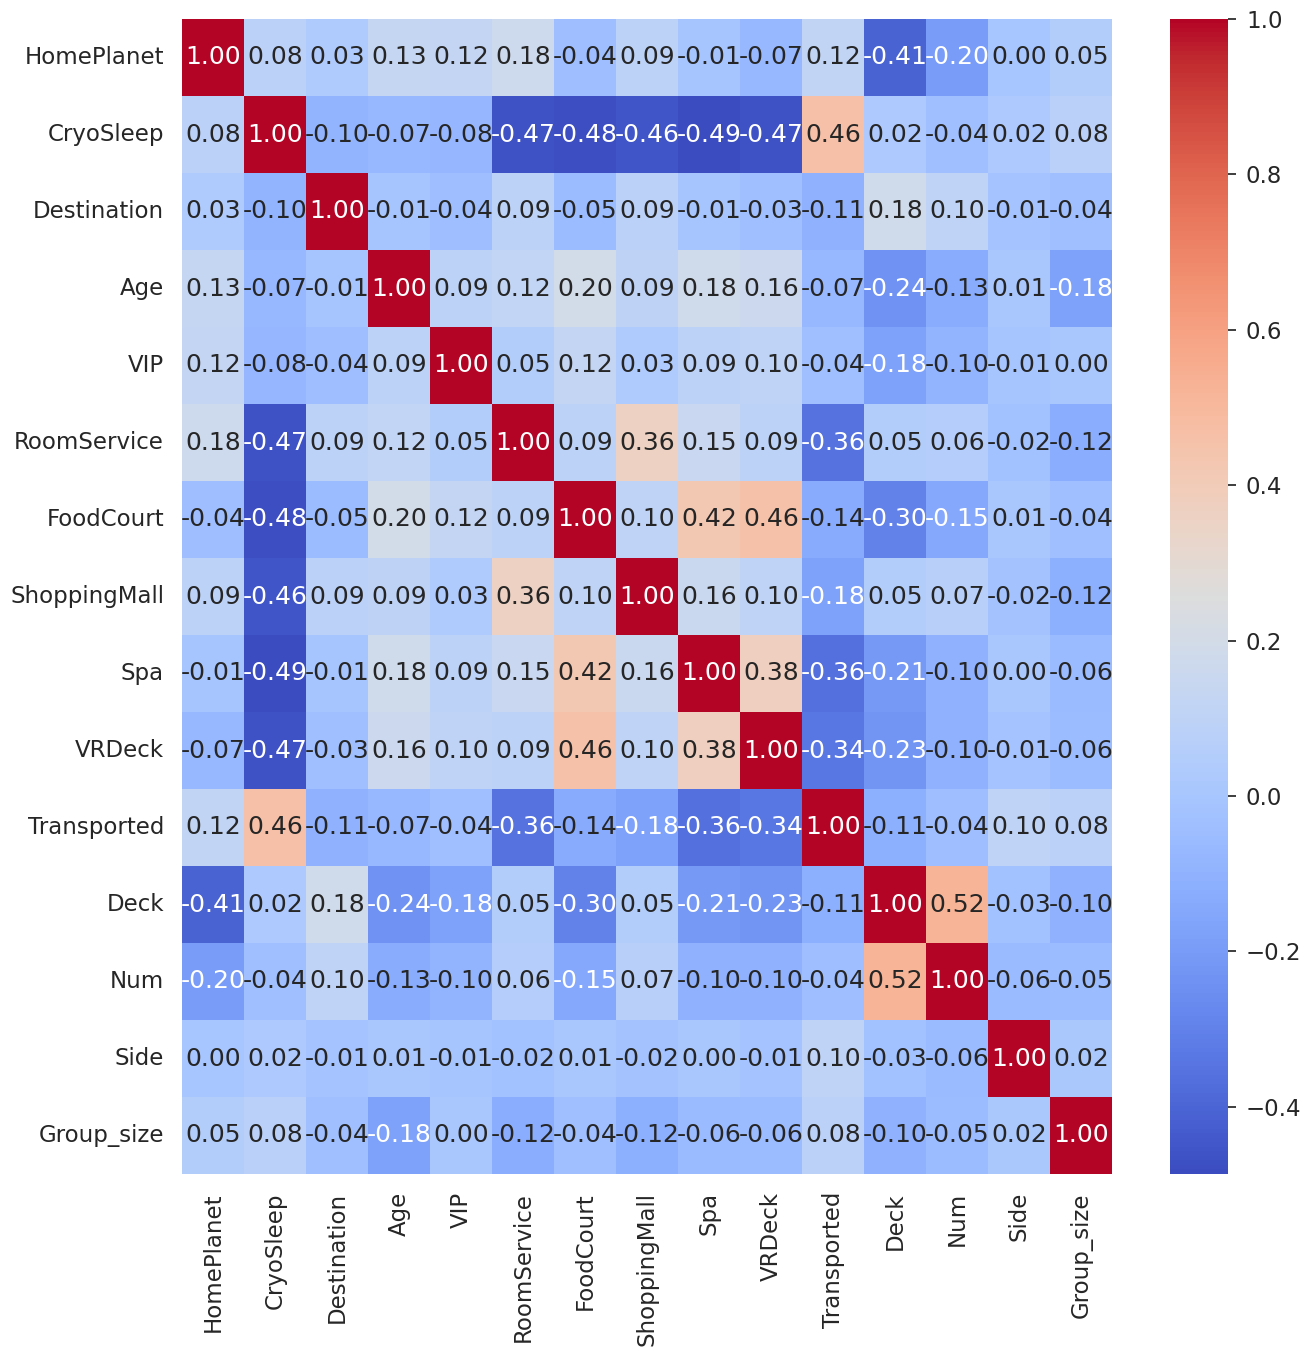

In [224]:
plt.figure(figsize=(15,15))
sns.heatmap(train_df.corr( ) , cmap='coolwarm', annot=True, fmt = '.2f')
plt.show( )

In [225]:
train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,Group_size
0,1,0,2,39.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,False,1,0,0,1
1,0,0,2,24.0,0,4.700480,2.302585,3.258097,6.309918,3.806662,True,5,0,1,1
2,1,0,2,58.0,1,3.784190,8.182280,0.000000,8.812248,3.912023,False,0,0,1,2
3,1,0,2,33.0,0,0.000000,7.157735,5.918894,8.110728,5.267858,False,0,0,1,2
4,0,0,2,16.0,0,5.717028,4.262680,5.023881,6.338594,1.098612,True,5,1,1,1


In [226]:
X = train_df.drop('Transported', axis=1).copy()
Y = train_df['Transported'].copy()

In [227]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [228]:
clf_xgb = xgb.XGBClassifier(object='binary:logistic', missing=None)
clf_xgb.fit(
    X_train,
    Y_train,
    verbose=True,
    early_stopping_rounds=10,
    eval_metric='aucpr',
    eval_set=[(X_test,Y_test)]
)

[0]	validation_0-aucpr:0.87357
[1]	validation_0-aucpr:0.87975
[2]	validation_0-aucpr:0.88712
[3]	validation_0-aucpr:0.88770
[4]	validation_0-aucpr:0.89002
[5]	validation_0-aucpr:0.89294
[6]	validation_0-aucpr:0.89606
[7]	validation_0-aucpr:0.89891
[8]	validation_0-aucpr:0.89910
[9]	validation_0-aucpr:0.89996
[10]	validation_0-aucpr:0.90089
[11]	validation_0-aucpr:0.90104
[12]	validation_0-aucpr:0.90179
[13]	validation_0-aucpr:0.90202
[14]	validation_0-aucpr:0.90288
[15]	validation_0-aucpr:0.90399
[16]	validation_0-aucpr:0.90479
[17]	validation_0-aucpr:0.90477
[18]	validation_0-aucpr:0.90486
[19]	validation_0-aucpr:0.90555
[20]	validation_0-aucpr:0.90553
[21]	validation_0-aucpr:0.90594
[22]	validation_0-aucpr:0.90597
[23]	validation_0-aucpr:0.90597
[24]	validation_0-aucpr:0.90598
[25]	validation_0-aucpr:0.90599
[26]	validation_0-aucpr:0.90607
[27]	validation_0-aucpr:0.90568
[28]	validation_0-aucpr:0.90549
[29]	validation_0-aucpr:0.90565
[30]	validation_0-aucpr:0.90556
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=None, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, object='binary:logistic', ...)

In [229]:
param_grid={
    'max_depth': [3,4,5],
    'learning_rate': [1, 0.5, 0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0, 20, 100],
    'scale_pos_weght': [1, 3, 5]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(
        object='binary:logistic',
        subsample=0.9,
        colsample_bytree=0.5
    ),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3
)

In [230]:
clf_xgb = xgb.XGBClassifier(object='binary:logistic',
                            gamma=0.25,
                            learning_rate=0.1,
                            max_depth=4,
                            reg_lambda=10,
                            scale_pos_weght=3,
                            subsample=0.9,
                            colsample_bytree=0.5
                           )

clf_xgb.fit(
    X_train,
    Y_train,
    verbose=True,
    early_stopping_rounds=10,
    eval_metric='aucpr',
    eval_set=[(X_test,Y_test)]
)

[0]	validation_0-aucpr:0.80999
[1]	validation_0-aucpr:0.84522
[2]	validation_0-aucpr:0.84727
[3]	validation_0-aucpr:0.85362
[4]	validation_0-aucpr:0.85123
[5]	validation_0-aucpr:0.86329
[6]	validation_0-aucpr:0.86446
[7]	validation_0-aucpr:0.86149
[8]	validation_0-aucpr:0.86404
[9]	validation_0-aucpr:0.86419
[10]	validation_0-aucpr:0.86953
[11]	validation_0-aucpr:0.87051
[12]	validation_0-aucpr:0.87234
[13]	validation_0-aucpr:0.87333
[14]	validation_0-aucpr:0.87389
[15]	validation_0-aucpr:0.87316
[16]	validation_0-aucpr:0.87340
[17]	validation_0-aucpr:0.87583
[18]	validation_0-aucpr:0.87953
[19]	validation_0-aucpr:0.87958
[20]	validation_0-aucpr:0.87942
[21]	validation_0-aucpr:0.88175
[22]	validation_0-aucpr:0.88216
[23]	validation_0-aucpr:0.88351
[24]	validation_0-aucpr:0.88400
[25]	validation_0-aucpr:0.88423
[26]	validation_0-aucpr:0.88476
[27]	validation_0-aucpr:0.88615
[28]	validation_0-aucpr:0.88711
[29]	validation_0-aucpr:0.88798
[30]	validation_0-aucpr:0.88844
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, object='binary:logistic', ...)

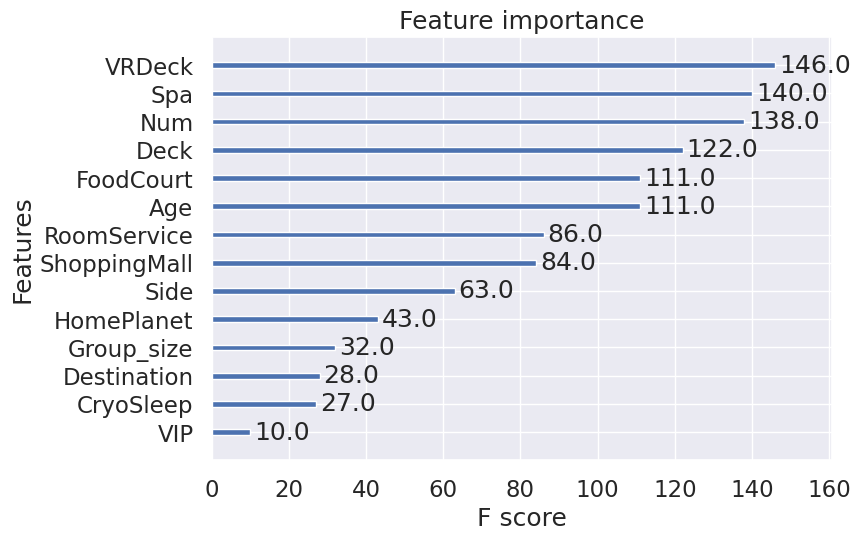

In [235]:
from xgboost import plot_importance

plot_importance(clf_xgb)

plt.show()

In [231]:
test_ids = test_df.pop('PassengerId')
X_pred = test_df.copy()

In [232]:
test_preds = clf_xgb.predict(X_pred)

In [233]:
submission = pd.DataFrame({'PassengerId': test_ids, 'Transported': test_preds})
submission['Transported'] = submission['Transported'].astype('boolean')
submission.to_csv('submission.csv', index=False)
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True
